<a href="https://colab.research.google.com/github/KimDongChan0908/Artificial-Intelligence-Programming/blob/week---13---class/CIFAR10_Code_Study_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10

* 이미지 크기 : 32 x 32
* channels = 3채널 (RGB)
* class : 10개의 상호 베타적(클래스당 6000장)


# Import Module

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.optim as optim
import time # 시간관련 기능을 알려주는 표준 라이브러리 => 시간 측정등

In [2]:
class_nmaes = ['airplane', 'car',
               'bird', 'cat',
               'deer', 'dog',
               'frog', 'horse',
               'ship', 'truck']

# Trainset 과 Testset 생성
 * CIFAR10 을 다운로드
 * train과 test를 위한 Dataset 생성


In [3]:
data_path = os.path.join('dataset')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(
         (0.4915, 0.4823, 0.4468),
         (0.2470, 0.2435, 0.2616),
         )
     ]
)

cifar10_train = datasets.CIFAR10(
    data_path,
    train = True,
    download = True,
    transform = transform,
)

cifar10_test = datasets.CIFAR10(
    data_path,
    train = False,
    download = True,
    transform = transform
)

100%|██████████| 170498071/170498071 [00:03<00:00, 56318431.38it/s]


Extracting dataset/cifar-10-python.tar.gz to dataset
Files already downloaded and verified


In [4]:
print(f'{type(transform)     = }')
print(f'{type(cifar10_train) = }')
print(f'{type(cifar10_test)  = }')

type(transform)     = <class 'torchvision.transforms.transforms.Compose'>
type(cifar10_train) = <class 'torchvision.datasets.cifar.CIFAR10'>
type(cifar10_test)  = <class 'torchvision.datasets.cifar.CIFAR10'>


In [5]:
train_size = int(0.8 * len(cifar10_train))
validation_size = len(cifar10_train) - train_size
train_set, validation_set = random_split(
    cifar10_train, [train_size, validation_size]
)

* batch_size = 32 로 설정 후 train, valid, test DataLoader 설정

In [6]:
batch_size = 32
n_worker = 0

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = batch_size,
    shuffle = True,
    num_workers = n_worker,
    )

valid_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size = batch_size,
    shuffle = False,
    num_workers = n_worker,
)

test_loader = torch.utils.data.DataLoader(
    cifar10_test,
    batch_size = batch_size,
    shuffle = False,
    num_workers = n_worker,
)

* 데이터 로더에서 반복하고 이미지를 시각화 하는 과정

type(grid_img)=<class 'torch.Tensor'>
max_val.item()=2.126077890396118
min_val.item()=-1.989878535270691


(-0.5, 273.5, 137.5, -0.5)

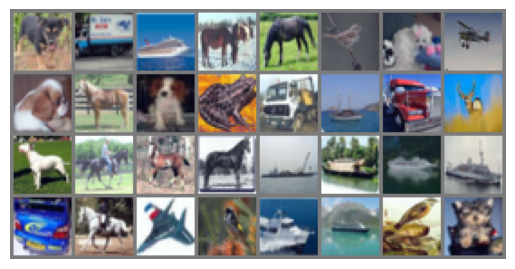

In [7]:
dataiter = iter(train_loader) #데이터 로더에서 반복자를 생성한다.
images, labels = next(dataiter) #반복자의 다음 요소 추출

grid_img = torchvision.utils.make_grid(images) #여러 이미지를 그리드 형태로 배치하여 하나의 이미지로 생성
max_val = torch.max(grid_img)
min_val = torch.min(grid_img)
print(f'{type(grid_img)=}\n{max_val.item()=}\n{min_val.item()=}')

normalized_grid_img = (grid_img - min_val) / (max_val - min_val) #이미지 정규화 진행
plt.imshow(np.transpose(normalized_grid_img, (1,2,0))) #이미지를 시각화 한다.
plt.axis('off')

# Train Loop

In [8]:
def train_loop (
        n_epoch,
        train_loader, val_loader,
        model,  optimizer, loss_fnc,
        device = 'cpu' ):
    log_hist = torch.zeros([0,3]).to(device)
    tmp = torch.empty((1, 3), device=log_hist.device)

    model = model.to(device)
    start_time = time.time()
    for epoch in range (n_epoch):

        model.train()
        for x_tensor, y_tensor in train_loader:
            x_tensor = x_tensor.to(device)
            y_tensor = y_tensor.to(device)

            y_pred = model(x_tensor)
            loss_train = loss_fnc(y_pred, y_tensor)

            if torch.isinf(loss_train):
                print(f'Error: loss is infinity!')
                break

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        with torch.no_grad():
            model.eval()
            for x_tensor, y_tensor in val_loader:
                x_tensor = x_tensor.to(device)
                y_tensor = y_tensor.to(device)
                pred = model(x_tensor)
                loss_val = loss_fnc(pred, y_tensor)

        if epoch % 5 == 0:

            tmp[0,0] = epoch
            tmp[0,1] = loss_train.item()
            tmp[0,2] = loss_val.item()

            log_hist = torch.concat( (log_hist, tmp.reshape(1,-1)), dim=0 )
            end_time = time.time()
            iteration_time = (end_time - start_time)
            print(f'{epoch} Epoch [{iteration_time:.2f}s]/ loss {loss_train.item():.4f} / val_loss {loss_val.item():.4f}')

            start_time = time.time()

        if epoch == n_epoch-1:
            tmp[0, 0] = epoch
            tmp[0, 1] = loss_train.item()
            tmp[0, 2] = loss_val.item()
            end_time = time.time()
            iteration_time = (end_time - start_time)  # 소요 시간을 초 단위로 계산
            print(f'{epoch} Epoch [{iteration_time:.2f}s] / loss {loss_train.item():.4f} / val_loss {loss_val.item():.4f}')
    return model,log_hist

# Model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x=self.pool(F.relu(self.conv1(x)))

        x=self.pool(F.relu(self.conv2(x)))
        x=torch.flatten(x,1)

        x = F.relu(self.fc1(x))

        x = F.relu(self.fc2(x))

        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [10]:
params = list(net.parameters())
print(f'{len(params) = }')
print(params[0].size())

len(params) = 10
torch.Size([6, 3, 5, 5])


In [11]:
tmp = torch.randn(1,3,32,32)
out = net(tmp)

In [12]:
print(out)

tensor([[0.0000, 0.0000, 0.0000, 0.0335, 0.0000, 0.0000, 0.0000, 0.1085, 0.0124,
         0.0000, 0.0000, 0.1236, 0.0527, 0.0596, 0.0953, 0.0879, 0.0283, 0.0123,
         0.0000, 0.0000, 0.0000, 0.0062, 0.0000, 0.0039, 0.0000, 0.0658, 0.0545,
         0.0463, 0.1325, 0.0000, 0.1587, 0.1321, 0.2698, 0.0000, 0.2591, 0.0352,
         0.1032, 0.0000, 0.0000, 0.0000, 0.0259, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0356, 0.0000, 0.0768, 0.0011, 0.0000, 0.1524, 0.0024, 0.0000, 0.0374,
         0.0000, 0.0000, 0.0000, 0.0194, 0.0626, 0.0000, 0.0622, 0.0000, 0.1474,
         0.0733, 0.0000, 0.1609, 0.1158, 0.0000, 0.0000, 0.0242, 0.1688, 0.0000,
         0.0000, 0.1328, 0.0965, 0.0000, 0.0427, 0.0000, 0.1528, 0.0123, 0.0110,
         0.0000, 0.0533, 0.0000]], grad_fn=<ReluBackward0>)


In [14]:
net.zero_grad()
out.backward(torch.randn(1,84))

# Training

In [15]:
device = (
      "cuda" if torch.cuda.is_available()
      else "mps"
      if torch.backends.mps.is_available()
      else "cpu"
  )
print(f"{device=}")

device='cpu'


In [16]:
n_epoch = 11

lr = 2e-4
loss_fnc = nn.CrossEntropyLoss()
model = Net()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

m, h = train_loop (
    n_epoch,
    train_loader, valid_loader,
    model, optimizer, loss_fnc,
    device = device)


0 Epoch [28.57s]/ loss 2.7046 / val_loss 3.5096
5 Epoch [144.93s]/ loss 2.4721 / val_loss 3.3650
10 Epoch [143.00s]/ loss 2.1220 / val_loss 3.4655
10 Epoch [0.00s] / loss 2.1220 / val_loss 3.4655


#Learning Curve

(3, 3)


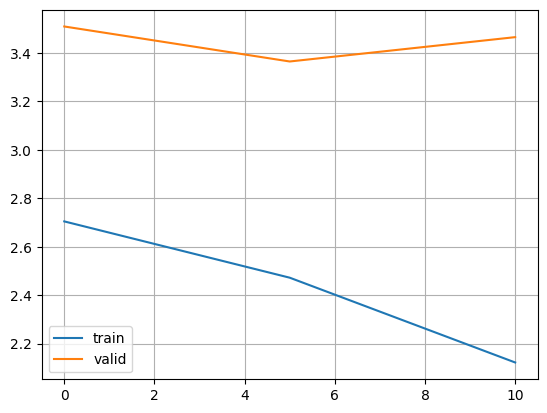

In [17]:
import matplotlib.pyplot as plt

h = h.cpu()
h0 = h.detach().numpy()
print(h0.shape)
plt.plot(h0[:,0], h0[:,1], label='train')
plt.plot(h0[:,0], h0[:,2], label='valid')
plt.legend()
plt.grid()
plt.show()

In [18]:
f_m = model.cpu()
f_m.eval()
with torch.no_grad():
  is_first = True
  for x_tensor, y_tensor in test_loader:
    x_tensor = x_tensor.cpu()
    y_tensor = y_tensor.cpu()
    pred_prob = f_m(x_tensor)
    pred = torch.argmax(pred_prob, dim=-1)

    if is_first:
      test_pred = pred.numpy().copy()
      test_label = y_tensor.numpy().copy()
      is_first = False
    else:
      test_label = np.concatenate((test_label, y_tensor.numpy()), axis=0)
      test_pred = np.concatenate((test_pred, pred.numpy()), axis=0)

print(test_label.shape, test_label.dtype)
print(test_pred.shape, test_pred.dtype)

(10000,) int64
(10000,) int64


#Confusion Matrix

In [19]:
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
)
pred = test_pred
label = test_label

print('Confusion Matrix\n',
      str(confusion_matrix(label,pred))
      )
print(f'Precision           :{np.round(precision_score(label,pred,average=None),2)}')
print(f'Precision (macro)   :{np.round(precision_score(label,pred,average="macro"),2)}')
print(f'Precision (micro)   :{np.round(precision_score(label,pred,average="micro"),2)}')
print(f'Precision (weighted):{np.round(precision_score(label,pred,average="weighted"),2)}')
print(f'Recall              :{np.round(recall_score(label,pred,average=None),2)}')
print(f'Recall    (macro)   :{np.round(recall_score(label,pred,average="macro"),2)}')
print(f'Recall    (micro)   :{np.round(recall_score(label,pred,average="micro"),2)}')
print(f'Recall    (weighted):{np.round(recall_score(label,pred,average="weighted"),2)}')
print(f'F1-score            :{np.round(f1_score(label,pred,average=None),2)}')
print(f'F1-score  (macro)   :{np.round(f1_score(label,pred,average="macro"),2)}')
print(f'F1-score  (micro)   :{np.round(f1_score(label,pred,average="micro"),2)}')
print(f'F1-score  (weighted):{np.round(f1_score(label,pred,average="weighted"),2)}')
print(f'F2-score            :{np.round(fbeta_score(label,pred,beta=2,average=None),2)}')
print(f'F2-score  (macro)   :{np.round(fbeta_score(label,pred,beta=2,average="macro"),2)}')
print(f'F2-score  (micro)   :{np.round(fbeta_score(label,pred,beta=2,average="micro"),2)}')
print(f'F2-score  (weighted):{np.round(fbeta_score(label,pred,beta=2,average="weighted"),2)}')

Confusion Matrix
 [[613   0   0  50  24  14  15  13 174  97]
 [ 96   0   0  45  11  14  15  15 161 643]
 [121   0   0 194 250 153  94  75  58  55]
 [ 32   0   0 496  67 192  72  54  38  49]
 [ 38   0   0 102 539  96  76  95  34  20]
 [ 20   0   0 256  67 500  22  86  20  29]
 [  8   0   0 132  97  48 651  18  21  25]
 [ 21   0   0  82  62  94  12 656  11  62]
 [ 58   0   0  31   9  15   3   8 813  63]
 [ 33   0   0  44  10  12   9  24  77 791]]
Precision           :[0.59 0.   0.   0.35 0.47 0.44 0.67 0.63 0.58 0.43]
Precision (macro)   :0.42
Precision (micro)   :0.51
Precision (weighted):0.42
Recall              :[0.61 0.   0.   0.5  0.54 0.5  0.65 0.66 0.81 0.79]
Recall    (macro)   :0.51
Recall    (micro)   :0.51
Recall    (weighted):0.51
F1-score            :[0.6  0.   0.   0.41 0.5  0.47 0.66 0.64 0.68 0.56]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1-score  (macro)   :0.45
F1-score  (micro)   :0.51
F1-score  (weighted):0.45
F2-score            :[0.61 0.   0.   0.46 0.52 0.49 0.66 0.65 0.75 0.68]
F2-score  (macro)   :0.48
F2-score  (micro)   :0.51
F2-score  (weighted):0.48
